In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import re
import datetime
#import mylib
#sns.set_style('whitegrid')
from scipy import stats
import statsmodels.formula.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,precision_score ,accuracy_score, recall_score


In [2]:
df = pd.read_csv('pae_survey_1.0.csv')

# Functions

In [3]:
# SEP utils file

def missing_heat_map(DataFrame):
    
    '''
    
    This function will plot the heatmap to display missing values
    Arguments: 
    DataFrame : takes a dataframe 
    
    Returns:
    A plot of missing values and a list of columns with percentages of missing values
    
    '''
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (18, 6))
    sns.heatmap(DataFrame.isnull(), yticklabels=False, ax = ax, cbar=False,\
                cmap='viridis')
    ax.set_title('dataset')
    plt.show()
        
    # Calculate the missing values to get a percentage 

    for i in DataFrame:
        print(i,': %',int((DataFrame[i].isnull().sum()/len(DataFrame[i]))*100),\
            'With {} missing values'.format((DataFrame[i].isnull().sum())))

In [4]:
    
def pie_chart(chart_name,name,column,varibles):
    
    '''

    This function will plot a pie chart
    Arguments:
    Chart_name : Takes string to display as chart title
    name : The file name that will be saved
    column : The column that will be plotted
    varibles : The number of unique values in the column
    
    '''
    
    pie, ax = plt.subplots(figsize=[10,6])
    labels = column.value_counts().keys()
    plt.pie(x=column.value_counts().values, autopct="%.1f%%", explode=[0.05]*int(varibles), labels=labels, pctdistance=0.5)
    plt.title("{}".format(chart_name), fontsize=14);
    pie.savefig("pics/{}.png".format(name))

In [5]:
def plot_corr(df):
    
    '''

    This function will plot the correlation
    Arguments:
    df: takes a data frame 
 
    Returns:
    a plot of the correlations in the data frame
    
    '''

    plt.figure(figsize=(20,10))
    corr=df.corr()
    sns.set(font_scale=2.5)
    sns.heatmap(corr,annot=True, vmin=0, vmax=1, cmap = 'gist_heat_r')



In [6]:
def magnify_corr(dataframe):

    '''

    This function will plot the correlation using an interactive plot
    Arguments:
    dataframe: takes a dataframe 
 
    Returns:
    a plot of the correlations in the data frame
    
    '''
    
    cmap=sns.diverging_palette(5, 250, as_cmap=True)
    corr = dataframe.corr()
    
    a = [dict(selector="th",props=[("font-size","7pt")]),
     dict(selector="td",props=[('padding',"0em 0em")]),
     dict(selector="th:hover",props=[("font-size","12pt")]),
     dict(selector="tr:hover td:hover",props=[('max-width','200px'),('font-size','12pt')])]
    
    
    return corr.style.background_gradient(cmap, axis=1)\
        .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
        .set_caption("Hover to magify")\
        .set_precision(2)\
        .set_table_styles(a)



In [7]:
def top_corr_features(target,number,dataframe):
    
    '''

    This function will give you the required number of highest correlated features to a target 
    Arguments:
    target: column name in string format of the targeted column
    number: The number of highest correlated features required
    data frame: the data frame name without parenthesis 

    returns: A list of the highest correlated features with the target (will also print the list)

    '''

    best_feature_corr=dataframe.corr()[str(target)].sort_values(ascending=False)\
        .index[0:int(number)].tolist()
    print('list of {} best positive features based on pairwise correlation:\n'\
        .format(number),best_feature_corr)
    return best_feature_corr

In [8]:

def top_corr_features_neg(target,number,dataframe):
    
    '''
    
    This function will give you the required number of highest correlated features to a target 
    Arguments:
    target: column name in string format of the targeted column
    number: The number of highest correlated features required
    data frame: the data frame name without parenthesis 

    returns: A list of the highest correlated features with the target (will also print the list)
    
    '''
    
    best_feature_corr=dataframe.corr()[str(target)].sort_values(ascending=True)\
        .index[0:int(number)].tolist()
    print('list of {} best positive features based on pairwise correlation:\n'\
        .format(number),best_feature_corr)
    return best_feature_corr

# Data preparation and Understanding

In [9]:
df.head()

,Timestamp,1) What is your gender?,2) What is your marital status?,3) In which region are you located?,4) Did you get your bachelor degree in Saudi or Abroad?,"5) If you have a master's degree, did you study in Saudi or Abroad? If not applicable, please choose N/A.",6) Have you ever studied in a mixed-sex university?,"7) After you spend a long day, how do you gain energy?",8) The people who know you best are more likely to describe you as someone who is:,9) Do you think that household chores should be equally divided between men and women? [Choose:],10) Do you prefer working in a single-sex work environment or mixed-sex work environment?,11) In your previous work/internship experience: how comfortable did you feel talking to members of the opposite gender? [Choose:],"12) If someone from the opposite gender has the information you need at work, how likely will you ask for the information? [Choose:]",13) How likely are you willing to work on a project with someone from the opposite gender? [Choose:],"14) If you studied abroad, can you identify any event that influenced your views about gender?",15) Are you with or against mixed-sex universities in Saudi?,16) What do you think about having mixed-sex universities in Saudi? Please list three reasons why or why not.
0,2020/12/02 1:19:18 PM GMT+3,Female,Single,Eastern,Abroad,NaN,"Yes, undergrad",Inner reflection and solitude,Quiet and reflective,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,NaN,Against mixed-sex universities,NaN
1,2020/12/02 1:21:06 PM GMT+3,Male,Single,Center,Saudi,Abroad,"Yes, grad",Going out with friends,Outgoing and talkative,2: Disagree,Single-sex work environment,3: Comfortable,3: Likely,3: Likely,NaN,Against mixed-sex universities,"Against it, privacy, competitiveness, security"
2,2020/12/02 1:29:40 PM GMT+3,Male,Single,Center,Saudi,NaN,"No, neither",Inner reflection and solitude,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,NaN,With mixed-sex universities,"Open mind, ice breaks and better environment"
3,2020/12/02 1:31:00 PM GMT+3,Female,Single,Center,Saudi,NaN,"No, neither",Inner reflection and solitude,Outgoing and talkative,3: Agree,Single-sex work environment,3: Comfortable,4: Highly likely,3: Likely,NaN,Against mixed-sex universities,1- it’s could be a problem in our society’s cu...
4,2020/12/02 1:36:05 PM GMT+3,Female,Single,Eastern,Saudi,NaN,"No, neither",Going out with friends,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,3: Comfortable,4: Highly likely,4: Highly likely,NaN,With mixed-sex universities,I agree.\n1. Preparing students for mixed-sex ...


In [10]:
# Column names that need to be changed for better analysis 
df.columns

Index(['Timestamp', '1) What is your gender? ',
       '2) What is your marital status? ',
       '3) In which region are you located? ',
       '4) Did you get your bachelor degree in Saudi or Abroad?',
       '5) If you have a master's degree, did you study in Saudi or Abroad? If not applicable, please choose N/A.',
       '6) Have you ever studied in a mixed-sex university? ',
       '7) After you spend a long day, how do you gain energy? ',
       '8) The people who know you best are more likely to describe you as someone who is:',
       '9) Do you think that household chores should be equally divided between men and women? [Choose:]',
       '10) Do you prefer working in a single-sex work environment or mixed-sex work environment? ',
       '11) In your previous work/internship experience: how comfortable did you feel talking to members of the opposite gender?  [Choose:]',
       '12) If someone from the opposite gender has the information you need at work, how likely will you as

In [11]:
#Changing column names
df.rename(columns={'1) What is your gender? ':'gender',
                   '2) What is your marital status? ':'marital_status',
                   '3) In which region are you located? ':'region',
                   '4) Did you get your bachelor degree in Saudi or Abroad?':'bachelor_loc',
                   "5) If you have a master's degree, did you study in Saudi or Abroad? If not applicable, please choose N/A.":"masters_loc",
                   '6) Have you ever studied in a mixed-sex university? ':'mixed_sex',
                   '7) After you spend a long day, how do you gain energy? ':'introversion_personal',
                   '8) The people who know you best are more likely to describe you as someone who is:':'introversion_public',
                   '9) Do you think that household chores should be equally divided between men and women? [Choose:]':'household_chores',
                   '10) Do you prefer working in a single-sex work environment or mixed-sex work environment? ':'single_vs_mixed_working_env',
                   '11) In your previous work/internship experience: how comfortable did you feel talking to members of the opposite gender?  [Choose:]':'comfort_with_other_gender',
                   '12) If someone from the opposite gender has the information you need at work, how likely will you ask for the information?  [Choose:]':'comfort_with_help_from_other_gender',
                   '13) How likely are you willing to work on a project with someone from the opposite gender? [Choose:]':'project_with_other_gender',
                   '14) If you studied abroad, can you identify any event that influenced your views about gender?':'events_that_influnced_gender_views',
                   '15) Are you with or against mixed-sex universities in Saudi? ':'with_or_aginst_mixed_sex_universities',
                   '16) What do you think about having mixed-sex universities in Saudi? Please list three reasons why or why not.':'opinion_mixed_sex_universites',
                   'Timestamp':'timestamp'
    
                  },inplace=True)

In [12]:
# New Column names
df.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites'],
      dtype='object')

In [13]:
df['comfort_with_help_from_other_gender'].value_counts()

4: Highly likely      81
3: Likely             22
2: Unlikely            5
1: Highly unlikely     1
Name: comfort_with_help_from_other_gender, dtype: int64

In [14]:
df['single_vs_mixed_working_env'].value_counts()

Mixed-sex work environment     83
Single-sex work environment    26
Name: single_vs_mixed_working_env, dtype: int64

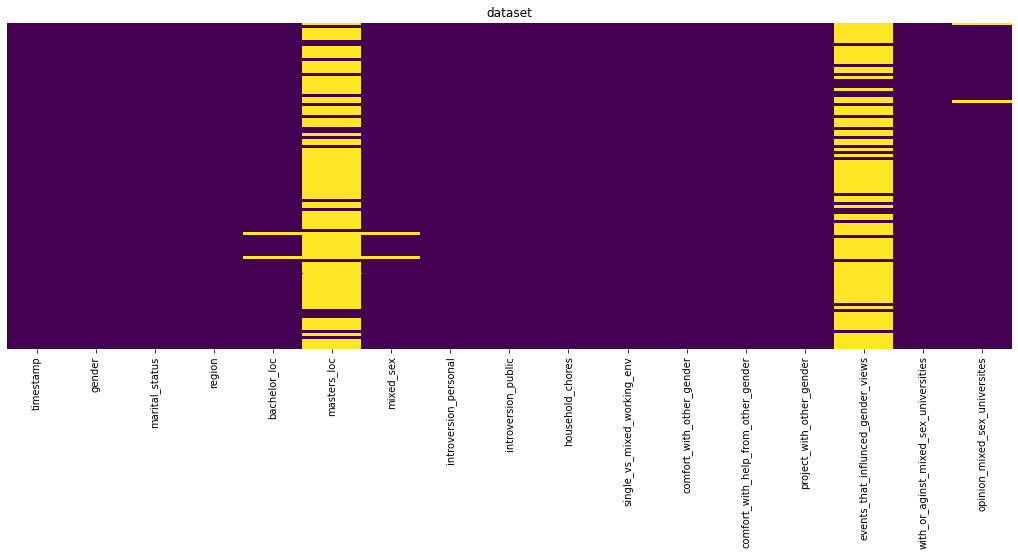

timestamp : % 0 With 0 missing values
gender : % 0 With 0 missing values
marital_status : % 0 With 0 missing values
region : % 0 With 0 missing values
bachelor_loc : % 1 With 2 missing values
masters_loc : % 80 With 88 missing values
mixed_sex : % 1 With 2 missing values
introversion_personal : % 0 With 0 missing values
introversion_public : % 0 With 0 missing values
household_chores : % 0 With 0 missing values
single_vs_mixed_working_env : % 0 With 0 missing values
comfort_with_other_gender : % 0 With 0 missing values
comfort_with_help_from_other_gender : % 0 With 0 missing values
project_with_other_gender : % 0 With 0 missing values
events_that_influnced_gender_views : % 77 With 84 missing values
with_or_aginst_mixed_sex_universities : % 0 With 0 missing values
opinion_mixed_sex_universites : % 1 With 2 missing values


In [15]:
# missing values
missing_heat_map(df)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   timestamp                              109 non-null    object
 1   gender                                 109 non-null    object
 2   marital_status                         109 non-null    object
 3   region                                 109 non-null    object
 4   bachelor_loc                           107 non-null    object
 5   masters_loc                            21 non-null     object
 6   mixed_sex                              107 non-null    object
 7   introversion_personal                  109 non-null    object
 8   introversion_public                    109 non-null    object
 9   household_chores                       109 non-null    object
 10  single_vs_mixed_working_env            109 non-null    object
 11  comfort_with_other_

## Timestamp

- Changed timestamp to Datetime format
- no missing values


In [17]:
#fixed to datetime format
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.datetime.strptime(x.strip('+3'), '%Y/%m/%d %H:%M:%S %p %Z'))

In [18]:
df['timestamp']

0     2020-12-02 01:19:18
1     2020-12-02 01:21:06
2     2020-12-02 01:29:40
3     2020-12-02 01:31:00
4     2020-12-02 01:36:05
              ...        
104   2020-12-17 01:48:06
105   2020-12-17 01:50:29
106   2020-12-18 04:14:52
107   2020-12-20 04:14:56
108   2020-12-21 11:06:58
Name: timestamp, Length: 109, dtype: datetime64[ns]

## gender
**1) What is your gender?**
- No missing values
- two unique values (Male/Female)

In [19]:
df['gender'].isnull().sum()

0

In [20]:
df['gender'].value_counts()

Male      68
Female    41
Name: gender, dtype: int64

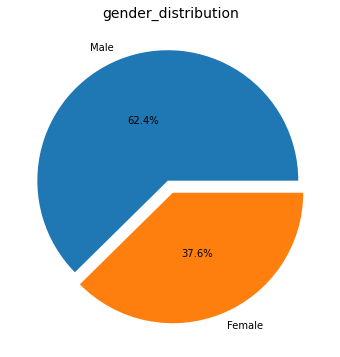

In [21]:
pie_chart('gender_distribution','gender_pie',df['gender'],2)

<AxesSubplot:xlabel='gender', ylabel='Count'>

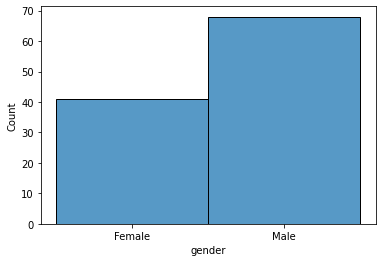

In [22]:
sns.histplot(df['gender'])

## marital_status
**2) What is your marital status?** 
- No null values
- Two uniqe values (Single/Married)


In [23]:
df['marital_status'].value_counts()

Single     101
Married      8
Name: marital_status, dtype: int64

In [24]:
df['marital_status'].isnull().sum()

0

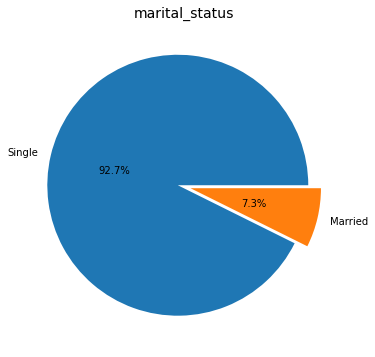

In [25]:
pie_chart('marital_status','marital_status_pie',df['marital_status'],2)

<AxesSubplot:xlabel='marital_status', ylabel='Count'>

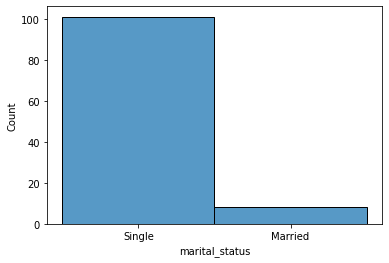

In [26]:
sns.histplot(df['marital_status'])

## region
**3) In which region are you located?**
- No missing values
- 4 unique values With most responds being in the centeral part of the region (%57.8)
- One missing region (South)

In [27]:
df['region'].isnull().sum()

0

In [28]:
df['region'].value_counts()

Center     63
Western    27
Eastern    18
Nothern     1
Name: region, dtype: int64

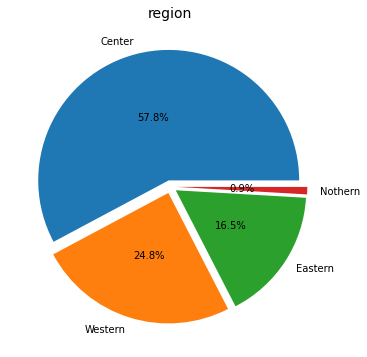

In [29]:
pie_chart('region','region_pie',df['region'],4)

<AxesSubplot:xlabel='region', ylabel='Count'>

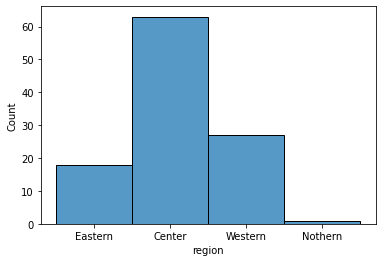

In [30]:
sns.histplot(df['region'])

## bachelor_loc
**4) Did you get your bachelor degree in Saudi or Abroad?**

- two missing values
- two uniqe values (Saudi/Abroad)


In [31]:
df['bachelor_loc'].isnull().sum()

2

In [32]:
df[df['bachelor_loc'].isnull()==True]

,timestamp,gender,marital_status,region,bachelor_loc,masters_loc,mixed_sex,introversion_personal,introversion_public,household_chores,single_vs_mixed_working_env,comfort_with_other_gender,comfort_with_help_from_other_gender,project_with_other_gender,events_that_influnced_gender_views,with_or_aginst_mixed_sex_universities,opinion_mixed_sex_universites
70,2020-12-06 05:02:25,Male,Single,Center,NaN,NaN,NaN,Inner reflection and solitude,Outgoing and talkative,2: Disagree,Single-sex work environment,3: Comfortable,3: Likely,3: Likely,NaN,Against mixed-sex universities,"Privacy, Competitiveness, Security"
78,2020-12-12 02:16:21,Male,Single,Center,NaN,NaN,NaN,Inner reflection and solitude,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,NaN,With mixed-sex universities,"Open mind, ice breaks and better environment"


In [34]:
df['bachelor_loc'].value_counts()

Saudi     70
Abroad    37
Name: bachelor_loc, dtype: int64

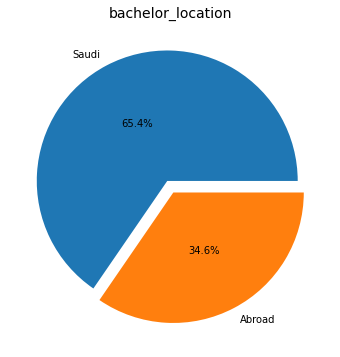

In [35]:
pie_chart('bachelor_location','bachelor_location_pie',df['bachelor_loc'],2)

In [36]:
df['bachelor_loc'].fillna('n/a',inplace=True)

<AxesSubplot:xlabel='bachelor_loc', ylabel='Count'>

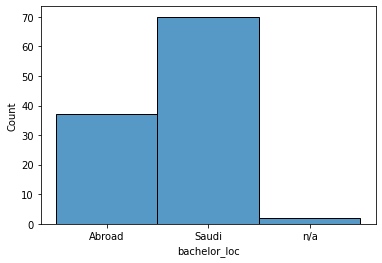

In [37]:
sns.histplot(df['bachelor_loc'])

## Masters_loc
**5) If you have a master's degree, did you study in Saudi or Abroad? If not applicable, please choose N/A**
- 88 missing values
- two uniqe values (Saudi/Abroad)

In [38]:
df['masters_loc'].isnull().sum()

88

In [39]:
df['masters_loc'].value_counts()

Abroad    15
Saudi      6
Name: masters_loc, dtype: int64

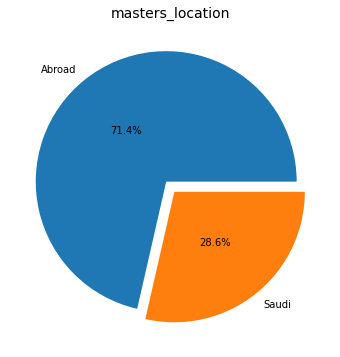

In [40]:
# Plot
pie_chart('masters_location','masters_location_pie',df['masters_loc'],2)

In [41]:
df['masters_loc'].fillna('n/a',inplace=True)

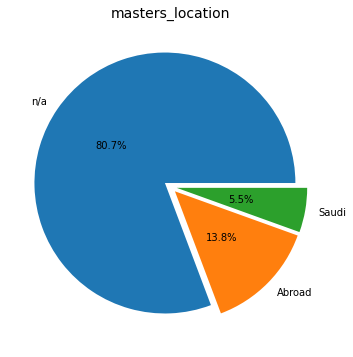

In [42]:
pie_chart('masters_location','masters_location_pie',df['masters_loc'],3)

<AxesSubplot:xlabel='masters_loc', ylabel='Count'>

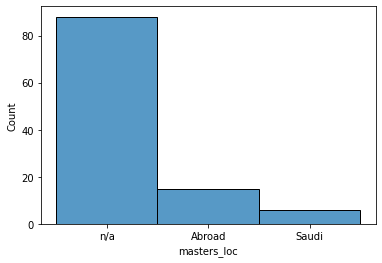

In [43]:
sns.histplot(df['masters_loc'])

## mixed_sex
**6) Have you ever studied in a mixed-sex university?**
- 2 missing values
- four possible choices

In [44]:
df['mixed_sex'].isnull().sum()

2

In [45]:
df[df['mixed_sex'].isnull()==True]


,timestamp,gender,marital_status,region,bachelor_loc,masters_loc,mixed_sex,introversion_personal,introversion_public,household_chores,single_vs_mixed_working_env,comfort_with_other_gender,comfort_with_help_from_other_gender,project_with_other_gender,events_that_influnced_gender_views,with_or_aginst_mixed_sex_universities,opinion_mixed_sex_universites
70,2020-12-06 05:02:25,Male,Single,Center,n/a,n/a,NaN,Inner reflection and solitude,Outgoing and talkative,2: Disagree,Single-sex work environment,3: Comfortable,3: Likely,3: Likely,NaN,Against mixed-sex universities,"Privacy, Competitiveness, Security"
78,2020-12-12 02:16:21,Male,Single,Center,n/a,n/a,NaN,Inner reflection and solitude,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,NaN,With mixed-sex universities,"Open mind, ice breaks and better environment"


In [46]:
df['mixed_sex'].value_counts()

Yes, undergrad    55
No, neither       33
Yes, grad         10
Yes, both          9
Name: mixed_sex, dtype: int64

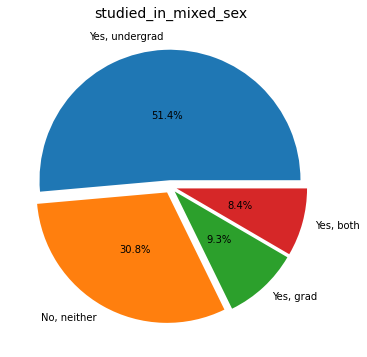

In [47]:
pie_chart('studied_in_mixed_sex','mixedsex_experince_pie',df['mixed_sex'],4)

In [48]:
df['mixed_sex'].fillna('n/a',inplace=True)

<AxesSubplot:xlabel='mixed_sex', ylabel='Count'>

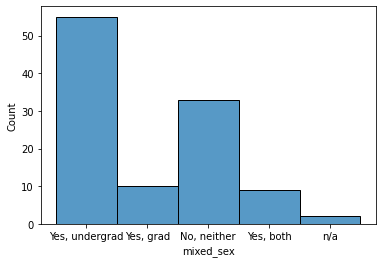

In [49]:
sns.histplot(df['mixed_sex'])

## introversion_personal
**7) After you spend a long day, how do you gain energy?**

- No missing values
- two unique values
- This will capture the persons perspetive on the level of introversion

In [50]:
df['introversion_personal'].value_counts()

Inner reflection and solitude    67
Going out with friends           42
Name: introversion_personal, dtype: int64

<AxesSubplot:xlabel='introversion_personal', ylabel='Count'>

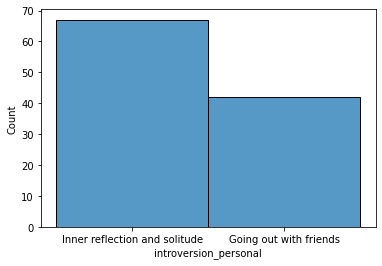

In [51]:
sns.histplot(df['introversion_personal'])

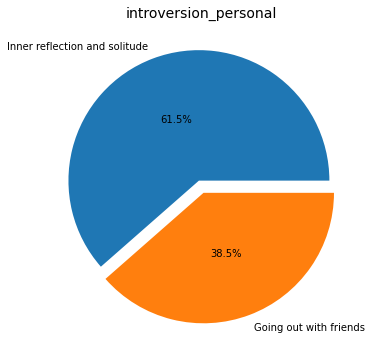

In [52]:
pie_chart('introversion_personal','introversion_personal_pie',df['introversion_personal'],2)

## introversion_public
**8) The people who know you best are more likely to describe you as someone who is:**
- No missing values
- two unique values 
- This will capture other peoples perspetive on the level of introversion 

In [53]:
df['introversion_public'].isnull().sum()

0

In [54]:
df['introversion_public'].value_counts()

Outgoing and talkative    66
Quiet and reflective      43
Name: introversion_public, dtype: int64

<AxesSubplot:xlabel='introversion_public', ylabel='Count'>

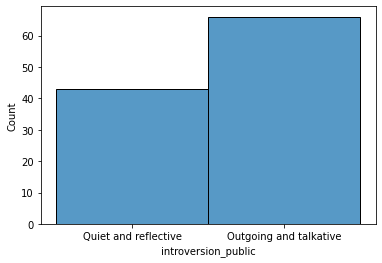

In [55]:
sns.histplot(df['introversion_public'])

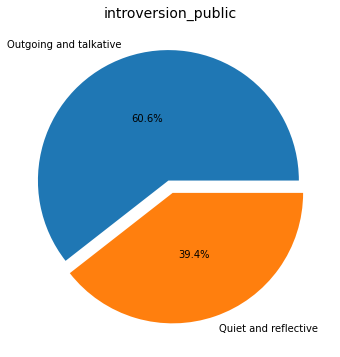

In [56]:
pie_chart('introversion_public','introversion_public_pie',df['introversion_public'],2)

## household_chores
**9) Do you think that household chores should be equally divided between men and women?**
- No missing values 
- four uniqe values (scale)

In [57]:
df['household_chores'].value_counts()

3: Agree                51
4: Strongly agree       36
2: Disagree             18
1: Strongly disagree     4
Name: household_chores, dtype: int64

In [58]:
df['household_chores'].isnull().sum()

0

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

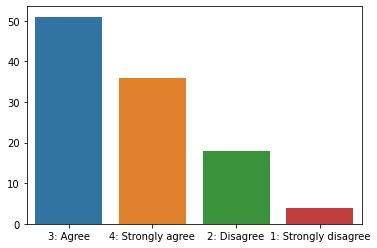

In [59]:
sns.barplot(df['household_chores'].value_counts().keys(),df['household_chores'].value_counts().values)

## single_vs_mixed_working_env
**10) Do you prefer working in a single-sex work environment or mixed-sex work environment?**
- No missing values 
- two uniqe values (scale)

In [63]:
df['single_vs_mixed_working_env'].value_counts()

Mixed-sex work environment     83
Single-sex work environment    26
Name: single_vs_mixed_working_env, dtype: int64

<AxesSubplot:xlabel='single_vs_mixed_working_env', ylabel='Count'>

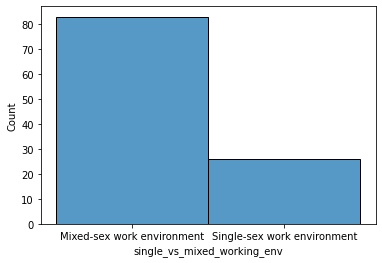

In [64]:
sns.histplot(df['single_vs_mixed_working_env'])

In [65]:
df['single_vs_mixed_working_env'].isnull().sum()

0

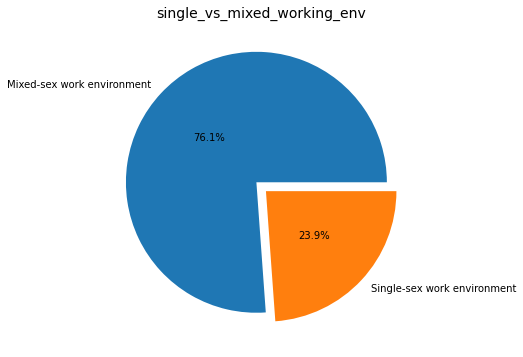

In [66]:
pie_chart('single_vs_mixed_working_env','single_vs_mixed_working_env_pie',df['single_vs_mixed_working_env'],2)

## comfort_with_other_gender
**11) In your previous work/internship experience: how comfortable did you feel talking to members of the opposite gender?**
- No missing values
- four unique values (scale)

In [67]:
df['comfort_with_other_gender'].value_counts()

3: Comfortable           47
4: Very comfortable      46
2: Uncomfortable         11
1: Very uncomfortable     5
Name: comfort_with_other_gender, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

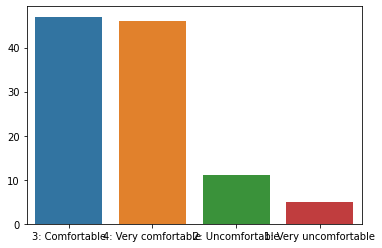

In [68]:
sns.barplot(df['comfort_with_other_gender'].value_counts().keys(),df['comfort_with_other_gender'].value_counts().values)

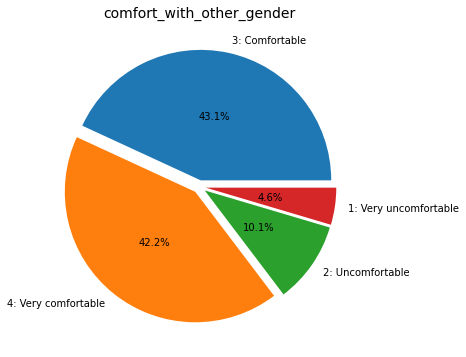

In [69]:
pie_chart('comfort_with_other_gender','comfort_with_other_gender_pie',df['comfort_with_other_gender'],4)

## comfort_with_help_from_other_gender
**12) If someone from the opposite gender has the information you need at work, how likely will you ask for the information?**
- No missing values
- four unique values (Scale)

In [72]:
df['comfort_with_help_from_other_gender'].value_counts()

4: Highly likely      81
3: Likely             22
2: Unlikely            5
1: Highly unlikely     1
Name: comfort_with_help_from_other_gender, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

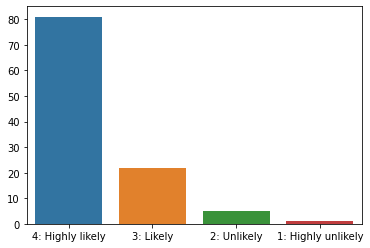

In [73]:
sns.barplot(df['comfort_with_help_from_other_gender'].value_counts().keys(),df['comfort_with_help_from_other_gender'].value_counts().values)

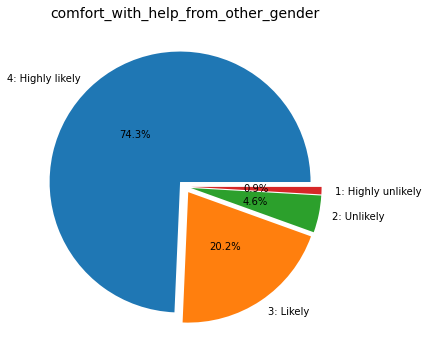

In [74]:
pie_chart('comfort_with_help_from_other_gender','comfort_with_help_from_other_gender_pie',df['comfort_with_help_from_other_gender'],4)

## project_with_other_gender
**13) How likely are you willing to work on a project with someone from the opposite gender?**
- No missing values
- four uniqe values (Scale)

In [75]:
df['project_with_other_gender'].isnull().sum()

0

In [76]:
df['project_with_other_gender'].value_counts()

4: Highly likely      74
3: Likely             24
2: Unlikely            8
1: Highly unlikely     3
Name: project_with_other_gender, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

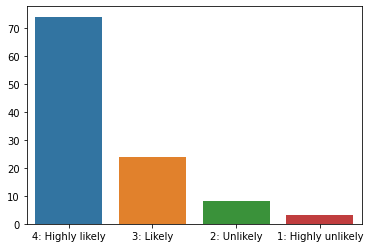

In [77]:
sns.barplot(df['project_with_other_gender'].value_counts().keys(),df['project_with_other_gender'].value_counts().values)

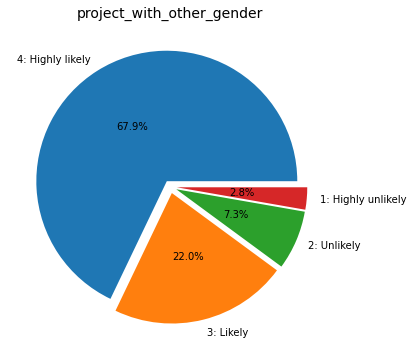

In [78]:
pie_chart('project_with_other_gender','project_with_other_gender_pie',df['project_with_other_gender'],4)

## events_that_influnced_gender_views
**14) If you studied abroad, can you identify any event that influenced your views about gender?**
- 89 missing values
- Text might quote from here


In [79]:
df['events_that_influnced_gender_views'].isnull().sum()

84

In [80]:
df['events_that_influnced_gender_views'].fillna('n/a',inplace=True)
df['events_that_influnced_gender_views'].replace([' ','?','.','Ok'],'n/a',inplace=True)

In [81]:
df['events_that_influnced_gender_views'].value_counts()

n/a                                                                                                                                                                                                                                                                                                                                                                                89
Student unions                                                                                                                                                                                                                                                                                                                                                                      1
Just got used to it with time                                                                                                                                                                                                                               

## with_or_aginst_mixed_sex_universities
**15) Are you with or against mixed-sex universities in Saudi?**
- No missing values
- two possible unique values
- Dependant varible

In [82]:
df['with_or_aginst_mixed_sex_universities'].isnull().sum()

0

In [83]:
df['with_or_aginst_mixed_sex_universities'].value_counts()

With mixed-sex universities       74
Against mixed-sex universities    35
Name: with_or_aginst_mixed_sex_universities, dtype: int64

<AxesSubplot:xlabel='with_or_aginst_mixed_sex_universities', ylabel='Count'>

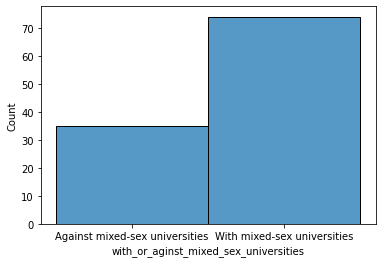

In [84]:
sns.histplot(df['with_or_aginst_mixed_sex_universities'])

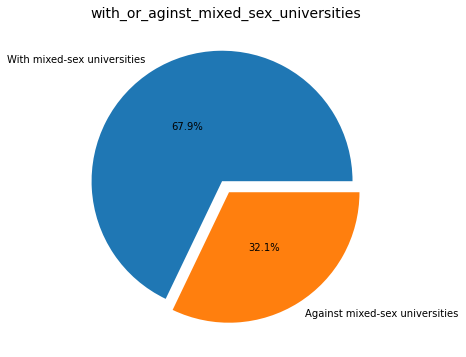

In [85]:
pie_chart('with_or_aginst_mixed_sex_universities','with_or_aginst_mixed_sex_universities_pie',df['with_or_aginst_mixed_sex_universities'],2)

In [ ]:
# case study reasurch +1

## opinion_mixed_sex_universites
**16) What do you think about having mixed-sex universities in Saudi? Please list three reasons why or why not**
- two missing values
- text data

In [86]:
df['opinion_mixed_sex_universites'].isnull().sum()

2

In [87]:
df['opinion_mixed_sex_universites'].fillna('n/a',inplace=True)
df['opinion_mixed_sex_universites'].replace([' ','?','.','Ok'],'n/a',inplace=True)

In [88]:
df['opinion_mixed_sex_universites'].value_counts()

n/a                                                                                                                                                         5
Because everyone deserve an opportunity                                                                                                                     3
It helps break the barrier that many end up facing in the workplace or if they travel. Mixing in a professional and decent manner shouldn’t be an issue.    2
1- university student tend to be immature \n2- I’m with partially mix\n3- not applicable in very city yet                                                   2
Both genders can understand eachother more                                                                                                                  2
                                                                                                                                                           ..
Young and not mature                                

In [89]:
df['opinion_mixed_sex_universites'].value_counts()

n/a                                                                                                                                                         5
Because everyone deserve an opportunity                                                                                                                     3
It helps break the barrier that many end up facing in the workplace or if they travel. Mixing in a professional and decent manner shouldn’t be an issue.    2
1- university student tend to be immature \n2- I’m with partially mix\n3- not applicable in very city yet                                                   2
Both genders can understand eachother more                                                                                                                  2
                                                                                                                                                           ..
Young and not mature                                

In [ ]:
#go over and quote

In [90]:
for i in df['opinion_mixed_sex_universites']:
    print(i)

n/a
Against it, privacy, competitiveness, security
Open mind, ice breaks and  better environment
1- it’s could be a problem in our society’s culture, 2- could create problems sexually, 3- could create issues with academic performance
I agree.
1. Preparing students for mixed-sex working places
2. Learning how to become comfortable with the other sex 
3. Getting used to the boadaries between both sexes. 
1- it would help our society shed their antiquated ideas about gender roles
2- prepares a new generation for the already unsegregated work environment
3- reducing the unnecessary costs of having two campuses 
Bring diversity, get them prepared for work culture, integration 
Mixed-sex can improve the quality of education 
Less cost 
Less resources
Great idea
Great
Great
I am only against It because of one reason. It is hard to stay in hijab all day especially the face cover. 
Both genders can understand eachother more
I think it’ll be good
It helps break the barrier that many end up facin

# Basic EDA

In [91]:

corr_df1 = df.copy()

In [92]:
corr_df1.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites'],
      dtype='object')

In [93]:
#select the features to drop because it will intoduce a huge number of features when dummied 
features = ['timestamp','events_that_influnced_gender_views','opinion_mixed_sex_universites']
select_features = [x for x in corr_df1.columns if x not in features] 
select_features 

['gender',
 'marital_status',
 'region',
 'bachelor_loc',
 'masters_loc',
 'mixed_sex',
 'introversion_personal',
 'introversion_public',
 'household_chores',
 'single_vs_mixed_working_env',
 'comfort_with_other_gender',
 'comfort_with_help_from_other_gender',
 'project_with_other_gender',
 'with_or_aginst_mixed_sex_universities']

In [94]:
# Create a test varible to test the corrilation with select features 
test = corr_df1[select_features] 
print(len(test))

109


In [95]:
test.head()

,gender,marital_status,region,bachelor_loc,masters_loc,mixed_sex,introversion_personal,introversion_public,household_chores,single_vs_mixed_working_env,comfort_with_other_gender,comfort_with_help_from_other_gender,project_with_other_gender,with_or_aginst_mixed_sex_universities
0,Female,Single,Eastern,Abroad,n/a,"Yes, undergrad",Inner reflection and solitude,Quiet and reflective,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,Against mixed-sex universities
1,Male,Single,Center,Saudi,Abroad,"Yes, grad",Going out with friends,Outgoing and talkative,2: Disagree,Single-sex work environment,3: Comfortable,3: Likely,3: Likely,Against mixed-sex universities
2,Male,Single,Center,Saudi,n/a,"No, neither",Inner reflection and solitude,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,With mixed-sex universities
3,Female,Single,Center,Saudi,n/a,"No, neither",Inner reflection and solitude,Outgoing and talkative,3: Agree,Single-sex work environment,3: Comfortable,4: Highly likely,3: Likely,Against mixed-sex universities
4,Female,Single,Eastern,Saudi,n/a,"No, neither",Going out with friends,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,3: Comfortable,4: Highly likely,4: Highly likely,With mixed-sex universities


In [96]:
#Converting the data into dummies to apply to check corrilations (test_dummies)
test_dummies = pd.get_dummies(test,drop_first=True)
test_dummies.head()

,gender_Male,marital_status_Single,region_Eastern,region_Nothern,region_Western,bachelor_loc_Saudi,bachelor_loc_n/a,masters_loc_Saudi,masters_loc_n/a,"mixed_sex_Yes, both",...,comfort_with_other_gender_2: Uncomfortable,comfort_with_other_gender_3: Comfortable,comfort_with_other_gender_4: Very comfortable,comfort_with_help_from_other_gender_2: Unlikely,comfort_with_help_from_other_gender_3: Likely,comfort_with_help_from_other_gender_4: Highly likely,project_with_other_gender_2: Unlikely,project_with_other_gender_3: Likely,project_with_other_gender_4: Highly likely,with_or_aginst_mixed_sex_universities_With mixed-sex universities
0,0,1,1,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
1,1,1,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,1,1,0,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,1,1
3,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
4,0,1,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,1,1


In [100]:
test['with_or_aginst_mixed_sex_universities'].value_counts()

With mixed-sex universities       74
Against mixed-sex universities    35
Name: with_or_aginst_mixed_sex_universities, dtype: int64

In [101]:
test_dummies['with_or_aginst_mixed_sex_universities_With mixed-sex universities'].value_counts()

1    74
0    35
Name: with_or_aginst_mixed_sex_universities_With mixed-sex universities, dtype: int64

In [102]:
test_dummies.columns

Index(['gender_Male', 'marital_status_Single', 'region_Eastern',
       'region_Nothern', 'region_Western', 'bachelor_loc_Saudi',
       'bachelor_loc_n/a', 'masters_loc_Saudi', 'masters_loc_n/a',
       'mixed_sex_Yes, both', 'mixed_sex_Yes, grad',
       'mixed_sex_Yes, undergrad', 'mixed_sex_n/a',
       'introversion_personal_Inner reflection and solitude',
       'introversion_public_Quiet and reflective',
       'household_chores_2: Disagree', 'household_chores_3: Agree',
       'household_chores_4: Strongly agree',
       'single_vs_mixed_working_env_Single-sex work environment',
       'comfort_with_other_gender_2: Uncomfortable',
       'comfort_with_other_gender_3: Comfortable',
       'comfort_with_other_gender_4: Very comfortable',
       'comfort_with_help_from_other_gender_2: Unlikely',
       'comfort_with_help_from_other_gender_3: Likely',
       'comfort_with_help_from_other_gender_4: Highly likely',
       'project_with_other_gender_2: Unlikely',
       'project_with_

In [103]:
magnify_corr(test_dummies)

,gender_Male,marital_status_Single,region_Eastern,region_Nothern,region_Western,bachelor_loc_Saudi,bachelor_loc_n/a,masters_loc_Saudi,masters_loc_n/a,"mixed_sex_Yes, both","mixed_sex_Yes, grad","mixed_sex_Yes, undergrad",mixed_sex_n/a,introversion_personal_Inner reflection and solitude,introversion_public_Quiet and reflective,household_chores_2: Disagree,household_chores_3: Agree,household_chores_4: Strongly agree,single_vs_mixed_working_env_Single-sex work environment,comfort_with_other_gender_2: Uncomfortable,comfort_with_other_gender_3: Comfortable,comfort_with_other_gender_4: Very comfortable,comfort_with_help_from_other_gender_2: Unlikely,comfort_with_help_from_other_gender_3: Likely,comfort_with_help_from_other_gender_4: Highly likely,project_with_other_gender_2: Unlikely,project_with_other_gender_3: Likely,project_with_other_gender_4: Highly likely,with_or_aginst_mixed_sex_universities_With mixed-sex universities
gender_Male,1.00,0.22,-0.01,0.07,0.14,-0.30,0.11,-0.14,0.00,-0.11,-0.08,0.29,0.11,-0.19,-0.15,0.35,-0.03,-0.26,-0.14,-0.18,-0.17,0.32,-0.01,-0.22,0.24,0.00,-0.32,0.28,-0.05
marital_status_Single,0.22,1.00,-0.06,0.03,0.16,0.01,0.04,-0.09,-0.05,-0.17,0.09,0.00,0.04,-0.08,0.08,0.13,-0.16,0.12,-0.17,-0.02,0.03,0.03,-0.11,-0.03,0.16,-0.06,-0.02,0.11,0.03
region_Eastern,-0.01,-0.06,1.00,-0.04,-0.26,-0.18,-0.06,0.00,-0.03,-0.04,-0.06,0.09,-0.06,-0.21,0.05,-0.13,-0.07,0.11,-0.13,0.10,-0.14,-0.03,0.02,-0.10,0.04,-0.03,-0.06,0.04,0.04
region_Nothern,0.07,0.03,-0.04,1.00,-0.06,0.07,-0.01,-0.02,0.05,0.32,-0.03,-0.10,-0.01,0.08,-0.08,-0.04,-0.09,0.14,-0.05,-0.03,-0.08,0.11,-0.02,-0.05,0.06,-0.03,-0.05,0.07,0.07
region_Western,0.14,0.16,-0.26,-0.06,1.00,-0.15,-0.08,-0.14,0.12,-0.02,-0.11,0.06,-0.08,0.10,0.10,0.03,-0.07,0.05,-0.12,0.02,-0.03,0.07,-0.13,0.03,0.05,0.16,-0.10,0.03,-0.02
bachelor_loc_Saudi,-0.30,0.01,-0.18,0.07,-0.15,1.00,-0.18,0.10,0.02,-0.26,0.24,-0.40,-0.18,0.04,0.13,0.13,-0.18,0.08,0.24,0.12,0.15,-0.29,0.16,-0.01,-0.09,0.14,0.03,-0.14,-0.10
bachelor_loc_n/a,0.11,0.04,-0.06,-0.01,-0.08,-0.18,1.00,-0.03,0.07,-0.04,-0.04,-0.14,1.00,0.11,-0.11,0.12,-0.13,0.05,0.08,-0.05,0.02,0.02,-0.03,0.10,-0.08,-0.04,0.09,-0.05,-0.05
masters_loc_Saudi,-0.14,-0.09,0.00,-0.02,-0.14,0.10,-0.03,1.00,-0.49,0.07,-0.08,-0.24,-0.03,0.19,-0.03,-0.11,0.10,-0.08,0.15,-0.08,-0.05,-0.12,0.33,-0.02,-0.23,-0.07,0.07,-0.26,-0.18
masters_loc_n/a,0.00,-0.05,-0.03,0.05,0.12,0.02,0.07,-0.49,1.00,-0.28,-0.41,0.35,0.07,-0.05,0.01,0.03,-0.15,0.15,0.06,0.09,0.05,-0.01,-0.12,0.01,0.09,0.14,-0.19,0.21,0.01
"mixed_sex_Yes, both",-0.11,-0.17,-0.04,0.32,-0.02,-0.26,-0.04,0.07,-0.28,1.00,-0.10,-0.30,-0.04,0.10,-0.04,-0.13,0.12,0.00,-0.01,-0.10,0.01,0.08,-0.07,0.02,0.02,-0.08,0.08,-0.01,0.13


In [104]:
# get the top 10 correlated features with price
pos_top_features = top_corr_features('with_or_aginst_mixed_sex_universities_With mixed-sex universities',10,test_dummies)
for i in pos_top_features:
    print(i)

list of 10 best positive features based on pairwise correlation:
 ['with_or_aginst_mixed_sex_universities_With mixed-sex universities', 'project_with_other_gender_4: Highly likely', 'comfort_with_help_from_other_gender_4: Highly likely', 'household_chores_4: Strongly agree', 'comfort_with_other_gender_3: Comfortable', 'mixed_sex_Yes, undergrad', 'mixed_sex_Yes, both', 'introversion_public_Quiet and reflective', 'comfort_with_other_gender_4: Very comfortable', 'region_Nothern']
with_or_aginst_mixed_sex_universities_With mixed-sex universities
project_with_other_gender_4: Highly likely
comfort_with_help_from_other_gender_4: Highly likely
household_chores_4: Strongly agree
comfort_with_other_gender_3: Comfortable
mixed_sex_Yes, undergrad
mixed_sex_Yes, both
introversion_public_Quiet and reflective
comfort_with_other_gender_4: Very comfortable
region_Nothern


In [ ]:
neg_top_features = top_corr_features_neg('with_or_aginst_mixed_sex_universities_With mixed-sex universities',10,test_dummies)
for i in neg_top_features:
    print(i)

In [ ]:
plot_corr(test_dummies[pos_top_features])

# Feature Extraction

In [ ]:
# ADD Conservitive and radical

## <font color='red'>introversion(new_feature)</font>

In [ ]:
introversion = []
for i in range(0,len(df)):
    if df['introversion_personal'][i]=='Going out with friends' and df['introversion_public'][i]=='Outgoing and talkative':
        introversion.append('extrovert')
    elif df['introversion_personal'][i]=='Inner reflection and solitude' and df['introversion_public'][i]=='Quiet and reflective':
        introversion.append('introvert')
    else:
        introversion.append('introvert/extrovert')
        
    
df['introversion'] = introversion

In [ ]:
df[['introversion_personal','introversion_public','introversion']].head(5)

In [ ]:
df['introversion'].head()

In [ ]:
df[['introversion','introversion_personal','introversion_public']].head(40)

In [ ]:
df['introversion'].value_counts()

In [ ]:
sns.histplot(df['introversion'])

In [ ]:
pie_chart('introversion','introversion_pie',df['introversion'],3)

In [ ]:
df.columns

## <font color='red'>mixed_sex_weighted</font>

In [ ]:
'''
    Weight mapper for mixed sex:
    6) Have you ever studied in a mixed-sex university?
    
    This function takes answers from question 6 and gives weights to possible inputs:
    
    Yes, undergrad == .75  
    No, neither == 0    
    Yes, grad == .5       
    Yes, both == 1

'''
def mixed_sex_mapper(data_point):
    i = data_point
    if i == 'Yes, both':
        return 1
    elif i == 'Yes, undergrad':
        return .75
    elif i == 'Yes, grad':
        return .5
    else :
        return 0

In [ ]:
df['mixed_sex_weighted'] = df['mixed_sex'].apply(lambda x: mixed_sex_mapper(x))

In [ ]:
df[['mixed_sex_weighted','mixed_sex']].value_counts()

In [ ]:
df[['mixed_sex_weighted','mixed_sex']].head(10)

## <font color='red'>household_chores_num</font>

In [ ]:
df['household_chores'].value_counts()

In [ ]:
df['household_chores_num'] = df['household_chores'].apply(lambda x : int(x.split(':')[0]))

In [ ]:
df[['household_chores_num','household_chores']].value_counts()

In [ ]:
df[['household_chores_num','household_chores']].head(10)

## <font color='red'>comfort_with_other_gender_num</font>

In [ ]:
df['comfort_with_other_gender'].value_counts()

In [ ]:
df['comfort_with_other_gender_num'] = df['comfort_with_other_gender'].apply(lambda x : int(x.split(':')[0]))

In [ ]:
df[['comfort_with_other_gender_num','comfort_with_other_gender']].value_counts()

In [ ]:
df[['comfort_with_other_gender_num','comfort_with_other_gender']].head(10)

## <font color='red'>comfort_with_help_from_other_gender_num</font>

In [ ]:
df['comfort_with_help_from_other_gender'].value_counts()

In [ ]:
df['comfort_with_help_from_other_gender_num'] = df['comfort_with_help_from_other_gender'].apply(lambda x : int(x.split(':')[0]))

In [ ]:
df[['comfort_with_help_from_other_gender_num','comfort_with_help_from_other_gender']]

In [ ]:
df.columns

## <font color='red'>project_with_other_gender_num</font>

In [ ]:
df['project_with_other_gender'].value_counts()

In [ ]:
df['project_with_other_gender_num'] = df['project_with_other_gender'].apply(lambda x : int(x.split(':')[0]))

In [ ]:
df[['project_with_other_gender_num','project_with_other_gender']]

### Ideas for feature engineering

- Conservitive vs radical
- ((Find quantitative data source))

## Explatory Data Analysis

In [ ]:
grouped_introversion=df[['introversion','gender','with_or_aginst_mixed_sex_universities']].groupby('introversion')
grouped_introversion.head()

#### Weight/Scale
**mixed_sex_weighted**
- weight : 
           Yes, undergrad == .75  
           No, neither == 0    
           Yes, grad == .5       
           Yes, both == 1 )
         
**household_chores_num**
- scale :  
           4: Strongly agree 
           3: Agree                     
           2: Disagree             
           1: Strongly disagree

**comfort_with_other_gender**
- Scale :  
           4: Very comfortable     
           3: Comfortable           
           2: Uncomfortable         
           1: Very uncomfortable 
         
**comfort_with_help_from_other_gender_num**
- Scale :  
           4: Highly likely    
           3: Likely           
           2: Unlikely    
           1: Highly Unlikely
         
**project_with_other_gender_num**
- Scale :  
           4: Highly likely    
           3: Likely           
           2: Unlikely    
           1: Highly Unlikely
'''

In [ ]:
df.groupby("gender").mean().T

In [ ]:
df.groupby("introversion").mean().T

# Model_preparation

In [ ]:
missing_heat_map(df)

In [ ]:
df.columns

In [ ]:
mod_df = df.copy()

In [ ]:
mod_df.columns

In [ ]:
#select the features to drop because it will intoduce a huge number of features when dummied 
features = ['opinion_mixed_sex_universites','events_that_influnced_gender_views',\
            'with_or_aginst_mixed_sex_universities','timestamp',\
            
            'introversion_personal','introversion_public','household_chores','comfort_with_other_gender',\
            'comfort_with_help_from_other_gender','project_with_other_gender']
select_features = [x for x in mod_df.columns if x not in features] 
select_features 

In [ ]:
x = mod_df[select_features] 
y = mod_df['with_or_aginst_mixed_sex_universities']
print(len(x),len(y))

In [ ]:
y.head()

In [ ]:
df.columns

### Dummies

In [ ]:
x = pd.get_dummies(x,drop_first=True) #Converting the data into dummies to apply to models
x.head()

In [ ]:
y = pd.get_dummies(y,drop_first=True)
y.head()

In [ ]:
df_corr = x.copy()

In [ ]:
df_corr['With mixed-sex universities'] = y

In [ ]:
df_corr.columns

In [ ]:
df['with_or_aginst_mixed_sex_universities'].value_counts()

In [ ]:
df_corr.columns

In [ ]:
magnify_corr(df_corr)

In [ ]:
# get the top 10 correlated features with dependent varible 
top_features = top_corr_features('With mixed-sex universities',10,df_corr)

In [ ]:
# Top positive corr
plot_corr(df_corr[top_features])

In [ ]:
#scaled the x varible 
scaler = StandardScaler()
x_ss = scaler.fit_transform(x)

In [ ]:
x.head()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y, test_size=0.3)

In [ ]:
x_train.columns

# Modeling

In [ ]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
print('Logreg predicted probabilities for x_test:\n', logreg.predict_proba(x_test))

In [ ]:
train_predicted = logreg.predict(x_train)
test_predicted = logreg.predict(x_test)
print('Logreg predicted labels:\n',test_predicted)

In [ ]:
y_test.head(40)

In [ ]:
x_train.head()

In [ ]:
len(x_train['mixed_sex_weighted'])

In [ ]:
len(y_test['With mixed-sex universities'])

In [ ]:
cross_val_score(logreg,x_train,y_train,cv=5).mean()

In [ ]:
cross_val_score(logreg,x_test,y_test,cv=5).mean()

- True Positive (TP): Outcome where the model correctly predicts the positive class.
- True Negative (TN): Outcome where the model correctly predicts the negative class.
- False Positive (FP): Also called a type 1 error, an outcome where the model incorrectly predicts the positive class when it is actually negative.
- False Negative (FN): Also called a type 2 error, an outcome where the model incorrectly predicts the negative class when it is actually positive.

In [ ]:
# Training confusion matrix
print(len(train_predicted))
tn, fp, fn, tp = confusion_matrix(y_train, train_predicted).ravel()
('TrueNegitive : {}'.format(tn), 'FalsePositive : {}'.format(fp), 'FalseNegitive : {}'.format(fn), 'TruePositive : {}'.format(tp))


In [ ]:
print('accuracy : {}'.format(accuracy_score(y_train, train_predicted)))
# Recall
print('recall : {}'.format(recall_score(y_train, train_predicted)))
# Precision
print('precision : {}'.format(precision_score(y_train, train_predicted)))

In [ ]:
# Testing confustion matrix 
print(len(test_predicted))
tn, fp, fn, tp = confusion_matrix(y_test, test_predicted).ravel()
('TrueNegitive : {}'.format(tn), 'FalsePositive : {}'.format(fp), 'FalseNegitive : {}'.format(fn), 'TruePositive : {}'.format(tp))

In [ ]:
print('accuracy : {}'.format(accuracy_score(y_test, test_predicted)))
# Recall
print('recall : {}'.format(recall_score(y_test, test_predicted)))
# Precision
print('precision : {}'.format(precision_score(y_test, test_predicted)))

In [ ]:
x.to_csv('mod.csv')

In [ ]:
df.head(50)

In [ ]:
x.columns

In [ ]:
x.to_csv('test.csv')